## Packages

In [1]:
import cv2
import glob
import json
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

torch.manual_seed(0)
np.random.seed(0)

## Load and Preprocess Data

In [2]:
class HOIDataset(Dataset):
    def __init__(self, transform, data_list, label_list):
        self.imgs_path = "vcoco_dataset/"
        self.transform = transform
        self.data = []
        for i in range(len(data_list)):
            img_path = data_list[i]
            class_name = label_list[i][0]
            true_class_name = label_list[i][1]
            agent_path = img_path + '/agent.jpg'
            object_path = img_path + '/object.jpg'
            union_path = img_path + '/union.jpg'
            self.data.append([agent_path, object_path, union_path, class_name, true_class_name])

        self.class_map = {
            'carry': 0,
            'catch_or_throw': 1,
            'lay': 2,
            'ride_or_sit': 3,
            'skateboard_or_snowboard': 4,
            'ski': 5,
            'surf': 6,
            'talk_on_phone': 7,
            'work_on_computer': 8
        }
    
    def __len__(self):
        return len(self.data)    
    
    def __getitem__(self, idx):
        agent_path, object_path, union_path, class_name, true_class_name = self.data[idx]
        agent_img = Image.open(agent_path)
        object_img = Image.open(object_path)
        union_img = Image.open(union_path)
        
        if self.transform:
            agent_img = self.transform(agent_img)
            object_img = self.transform(object_img)
            union_img = self.transform(union_img)

        trans = transforms.Compose([ 
            transforms.ToTensor() 
        ]) 
        agent = trans(agent_img)
        object = trans(object_img)
        union = trans(union_img)
        if class_name in ['ride', 'sit']:
            class_id = self.class_map['ride_or_sit']
        elif class_name in ['skateboard', 'snowboard']:
            class_id = self.class_map['skateboard_or_snowboard']
        elif class_name in ['catch', 'throw']:
            class_id = self.class_map['catch_or_throw']
        else:
            class_id = self.class_map[class_name]
        one_hot_class = torch.Tensor([0] * 9)
        one_hot_class[class_id] += 1
        
        return agent, object, union, one_hot_class, class_name, true_class_name

In [3]:
class PadToSquare:
    def __call__(self, image):
        w, h = image.size
        max_wh = max(w, h)
        hp = (max_wh - h) // 2
        wp = (max_wh - w) // 2
        padding = (wp, hp, wp, hp)
        return transforms.functional.pad(image, padding, fill=0, padding_mode='constant')
    
class Rescale:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        return transforms.functional.resize(image, self.output_size)

class PadAndRescale:
    def __init__(self, output_size):
        self.pad = PadToSquare()
        self.rescale = Rescale(output_size)

    def __call__(self, image):
        image = self.pad(image)
        image = self.rescale(image)
        return image


In [23]:
data_list = []
label_list = []
ride_list = []
imgs_path = "training_data/"
file_list = glob.glob(imgs_path + "*")
for class_path in file_list:
    class_name = class_path.split("\\")[-1]
    if class_name == 'ride':
        num_img = 0
        for img_path in glob.glob(class_path + "/*"):
            ride_list.append(img_path.split("/")[-1])
            data_list.append(img_path)
            label_list.append(('ride_or_sit', class_name))
            num_img += 1
            if num_img > 417:
                break

for class_path in file_list:
    class_name = class_path.split("\\")[-1]
    num_img = 0
    if class_name in ['hold', 'look', 'jump', 'point', 'read', 'kick', 'drink']:
        continue
    elif class_name == 'sit':
        for img_path in glob.glob(class_path + "/*"):
            if img_path.split("/")[-1] not in ride_list:
                data_list.append(img_path)
                label_list.append(('ride_or_sit', class_name))
                num_img += 1
                if num_img > 250:
                    break
    elif class_name in ['skateboard', 'snowboard']:
        for img_path in glob.glob(class_path + "/*"):
            data_list.append(img_path)
            label_list.append(('skateboard_or_snowboard', class_name))
            num_img += 1
            if num_img > 250:
                break
    elif class_name in ['catch', 'throw']:
        for img_path in glob.glob(class_path + "/*"):
            data_list.append(img_path)
            label_list.append(('catch_or_throw', class_name))
            num_img += 1
            if num_img > 250:
                break
    elif class_name != 'ride':
        for img_path in glob.glob(class_path + "/*"):
            data_list.append(img_path)
            label_list.append((class_name, class_name))
            num_img += 1
            if num_img > 417:
                break

# Split the dataset
train_data, test_data, train_labels, test_labels = train_test_split(data_list, label_list, test_size=0.1, random_state=42)

# Create HOIDatasets
transform = PadAndRescale(output_size=(128, 128))
train_dataset = HOIDataset(transform = transform, data_list = train_data, label_list = train_labels)
test_dataset = HOIDataset(transform = transform, data_list = test_data, label_list = test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Model

In [24]:
from torchvision import models
net = models.alexnet(pretrained=True)

net.classifier[6] = nn.Linear(in_features=4096, out_features=9, bias=True)
net.classifier.append(nn.Sigmoid())

net.train()

C:\Users\Microsoft\Anaconda\envs\AI\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Microsoft\Anaconda\envs\AI\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Human Stream and Object Stream

In [25]:
import copy

hs_model = copy.deepcopy(net)
os_model = copy.deepcopy(net)

### Pair Stream

In [26]:
ps_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(32, 64, kernel_size=5),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(64, 32, kernel_size=5),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Flatten(),
    nn.Dropout(p=0.5),
    nn.Linear(5408, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, 9),
    nn.Sigmoid()
)

## Training

### Hyperparameters

In [27]:
num_epochs = 5

In [28]:
criterion = nn.CrossEntropyLoss()

h_optimizer = optim.Adam(hs_model.parameters(), lr=0.0001)
o_optimizer = optim.Adam(os_model.parameters(), lr=0.0001)
p_optimizer = optim.Adam(ps_model.parameters(), lr=0.0001)

In [29]:
for epoch in range(num_epochs): 

    running_loss = 0.0
    correct = 0
    for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}')):
        
        h_input, o_input, p_input, y, class_name, _ = data
        
        h_optimizer.zero_grad()
        o_optimizer.zero_grad()
        p_optimizer.zero_grad()

        h_yhat = hs_model(h_input)
        o_yhat = os_model(o_input)
        p_yhat = ps_model(p_input)

        yhat = (h_yhat + o_yhat + p_yhat) / 3.0
        
        loss = criterion(yhat, y)
        loss.backward()
        h_optimizer.step()
        o_optimizer.step()
        p_optimizer.step()

        correct += sum(torch.argmax(yhat, 1)==torch.argmax(y, 1)).item()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            print(f'Training accuracy: {correct / 3200}')
            correct = 0
            running_loss = 0.0
            
    val_loss = 0.0
    val_steps = 0
    hs_model.eval()
    os_model.eval()
    ps_model.eval()
    
    with torch.no_grad():
        correct = 0
        wrong = 0
        action_real = [0] * 9
        action_predict = [0] * 9
        for val_data in tqdm(test_loader, desc=f'Validation Epoch {epoch + 1}'):
            h_input, o_input, p_input, y, class_name, _ = val_data
            
            h_yhat = hs_model(h_input)
            o_yhat = os_model(o_input)
            p_yhat = ps_model(p_input)

            y_hat = (h_yhat + o_yhat + p_yhat) / 3.0

            predicted = torch.argmax(y_hat.data, 1)
            action_predict[predicted] += 1

            true_labels = torch.argmax(y, 1)
            action_real[true_labels] += 1

            for i in range(len(true_labels)):
                if predicted==true_labels:
                    correct += 1
                else:
                    wrong += 1
            loss = criterion(y_hat, y)
            val_loss += loss.item()
            val_steps += 1

    avg_val_loss = val_loss / val_steps
    accuracy = correct / (correct + wrong)
    print(f'Epoch {epoch + 1} | validation loss: {avg_val_loss:.3f} | accuracy: {accuracy}')
    print(action_real)
    print(action_predict)

Epoch 1:  85%|████████████████████████████████████████████████████████████▏          | 100/118 [04:08<00:42,  2.38s/it]

[1,   100] loss: 1.905
Training accuracy: 0.495625


Validation Epoch 1: 100%|████████████████████████████████████████████████████████████| 419/419 [00:21<00:00, 19.26it/s]


Epoch 1 | validation loss: 1.782 | accuracy: 0.6443914081145584
[44, 32, 53, 78, 60, 42, 36, 29, 45]
[36, 35, 61, 98, 41, 44, 20, 31, 53]


Epoch 2:  85%|████████████████████████████████████████████████████████████▏          | 100/118 [03:37<00:37,  2.08s/it]

[2,   100] loss: 1.748
Training accuracy: 0.671875


Validation Epoch 2: 100%|████████████████████████████████████████████████████████████| 419/419 [00:20<00:00, 20.22it/s]


Epoch 2 | validation loss: 1.750 | accuracy: 0.6467780429594272
[44, 32, 53, 78, 60, 42, 36, 29, 45]
[51, 40, 40, 111, 41, 40, 51, 30, 15]


Epoch 3:  85%|████████████████████████████████████████████████████████████▏          | 100/118 [03:35<00:38,  2.16s/it]

[3,   100] loss: 1.701
Training accuracy: 0.7340625


Validation Epoch 3: 100%|████████████████████████████████████████████████████████████| 419/419 [00:22<00:00, 18.96it/s]


Epoch 3 | validation loss: 1.723 | accuracy: 0.7088305489260143
[44, 32, 53, 78, 60, 42, 36, 29, 45]
[42, 36, 58, 76, 56, 49, 30, 31, 41]


Epoch 4:  85%|████████████████████████████████████████████████████████████▏          | 100/118 [03:23<00:40,  2.25s/it]

[4,   100] loss: 1.661
Training accuracy: 0.77875


Validation Epoch 4: 100%|████████████████████████████████████████████████████████████| 419/419 [00:21<00:00, 19.13it/s]


Epoch 4 | validation loss: 1.693 | accuracy: 0.7255369928400954
[44, 32, 53, 78, 60, 42, 36, 29, 45]
[36, 35, 61, 75, 65, 44, 35, 24, 44]


Epoch 5:  85%|████████████████████████████████████████████████████████████▏          | 100/118 [03:30<00:36,  2.00s/it]

[5,   100] loss: 1.636
Training accuracy: 0.8246875


Validation Epoch 5: 100%|████████████████████████████████████████████████████████████| 419/419 [00:20<00:00, 20.39it/s]

Epoch 5 | validation loss: 1.696 | accuracy: 0.7565632458233891
[44, 32, 53, 78, 60, 42, 36, 29, 45]
[43, 43, 62, 52, 57, 46, 43, 29, 44]


In [30]:
# save weights
PATH = './hs_model_weights_with_classifier.pth'
torch.save(hs_model.state_dict(), PATH)

PATH = './os_model_weights_with_classifier.pth'
torch.save(os_model.state_dict(), PATH)

PATH = './ps_model_weights_with_classifier.pth'
torch.save(ps_model.state_dict(), PATH)

In [31]:
# Load the saved weights
PATH = './hs_model_weights_with_classifier.pth'
hs_model.load_state_dict(torch.load(PATH))
hs_model.eval()

PATH = './os_model_weights_with_classifier.pth'
os_model.load_state_dict(torch.load(PATH))
os_model.eval()

PATH = './ps_model_weights_with_classifier.pth'
ps_model.load_state_dict(torch.load(PATH))
ps_model.eval()

net = models.alexnet(pretrained=True)
net.classifier[6] = nn.Linear(in_features=4096, out_features=1, bias=True)
net.classifier.append(nn.Sigmoid())

PATH = './ride_sit_classifier_weights.pth'
ride_sit_model = copy.deepcopy(net)
ride_sit_model.load_state_dict(torch.load(PATH))
ride_sit_model.eval()

PATH = './skateboard_snowboard_classifier_weights.pth'
skate_snow_model = copy.deepcopy(net)
skate_snow_model.load_state_dict(torch.load(PATH))
skate_snow_model.eval()

PATH = './catch_throw_classifier_weights.pth'
catch_throw_model = copy.deepcopy(net)
catch_throw_model.load_state_dict(torch.load(PATH))
catch_throw_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Evaluation

In [32]:
class_map = {
    'carry': 0,
    'catch': 1,
    'lay': 2,
    'ride': 3,
    'sit': 4,
    'skateboard': 5,
    'ski': 6,
    'snowboard': 7,
    'surf': 8,
    'talk_on_phone': 9,
    'throw': 10,
    'work_on_computer': 11
}

predict_to_true_class_map = {
    0: 0,
    2: 2,
    5: 6,
    6: 8,
    7: 9,
    8: 11
}

In [33]:
correct = 0
wrong = 0
count = 0
predictions = []
true_label = []
for i, data in enumerate(test_loader):
    
    h_input, o_input, p_input, y, class_name, true_class_name = data
    
    h_yhat = hs_model(h_input)
    o_yhat = os_model(o_input)
    p_yhat = ps_model(p_input)
    
    yhat = (h_yhat + o_yhat + p_yhat) / 3.0
    
    # Get the predicted class for each input in the batch
    predicted = torch.argmax(yhat.data, 1).item()
    if predicted == 1:
        catch_throw_yhat = catch_throw_model(h_input).item()
        if catch_throw_yhat > 0.5:
            predicted = 10 # throw
        else:
            predicted = 1 # catch
    elif predicted == 3:
        ride_sit_yhat = ride_sit_model(o_input).item()
        if ride_sit_yhat > 0.5:
            predicted = 4 # sit
        else:
            predicted = 3 # ride
    elif predicted == 4:
        skate_snow_yhat = skate_snow_model(o_input).item()
        if skate_snow_yhat > 0.5:
            predicted = 5 # skateboard
        else:
            predicted = 7 # snowboard
    else:
        predicted = predict_to_true_class_map[predicted]
    
    predictions.append(predicted)
    
    # true_labels = torch.argmax(y, 1)
    true_label.append(class_map[true_class_name[0]])
    
    if predicted == class_map[true_class_name[0]]:
        correct += 1
    else:
        wrong += 1

accuracy = correct / (correct + wrong)
print(f"correct: {correct}, wrong: {wrong}, accuracy: {accuracy}")

correct: 307, wrong: 112, accuracy: 0.7326968973747017


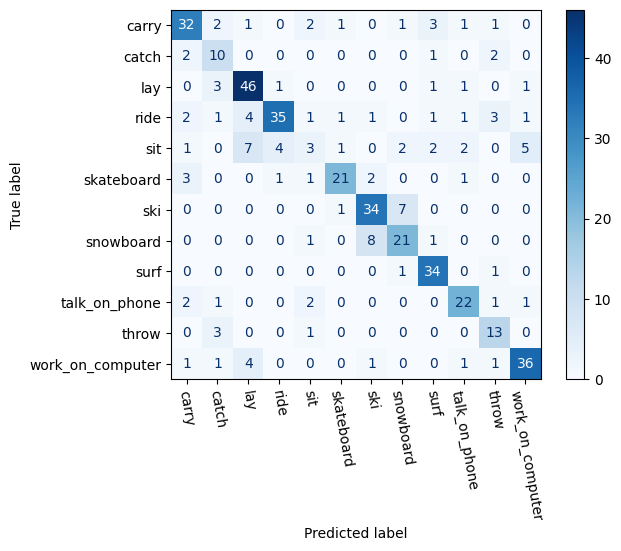

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

'''
# Ensure action_real and action_predict are defined
action_real = np.array(action_real)  
action_predict = np.array(action_predict)
action_real = action_real.squeeze()
action_predict = action_predict.squeeze()
'''
confusion_matrix = metrics.confusion_matrix(true_label, predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_map.keys())

cm_display.plot(cmap = 'Blues', xticks_rotation=280)
cm_display.figure_.savefig("confusion_matrix_with_classifier.png")
plt.show()